In [65]:
import sys
import os

# Add the 'src' directory to the Python path
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

from NeuralNetwork import Neural_Network
from GD_class import GradientDescent
from cost_functions import Cost_Functions
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import seaborn as sns

from tqdm import tqdm 


def grad_mse(target):
    
    def func(pred):
        
        n = len(target) # Number of inputs
        
        return 2/n * (pred - target)

    return func

def plot_heatmap(values, x_ticks, y_ticks, x_label, y_label, title):
    fig, ax = plt.subplots(figsize = (6, 5))
    heatmap = sns.heatmap(values, annot=True, ax=ax, cmap="viridis")
    heatmap.set_xticklabels(x_ticks)
    heatmap.set_yticklabels(y_ticks)
    ax.set_title(title)
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)
    plt.show()

In [72]:
def FrankeFunction(x,y):
    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [73]:
N = 1000
x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)

# Franke function with added noise:
z = FrankeFunction(x, y) + np.random.normal(0, 0.1, x.shape)
target = jnp.array(z).reshape(len(z), 1)

# Making the design matrix:
X = jnp.stack((x, y), axis=-1)

# Splitting the data into training and test set:
test_size = 0.2
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=test_size)

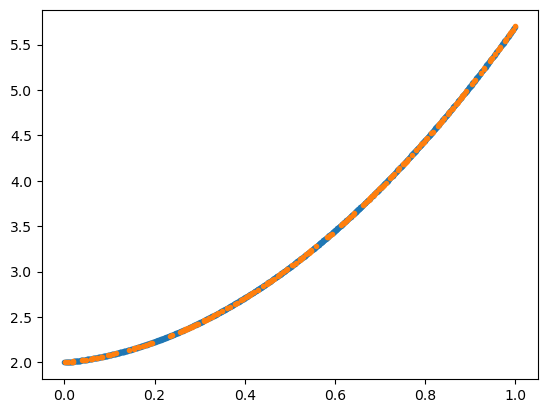

In [50]:
np.random.seed(1342)

n = 1000
true_beta = [2, 0.5, 3.2]

x = jnp.linspace(0, 1, n)

target = jnp.sum(jnp.asarray([x ** p * b for p, b in enumerate(true_beta)]),
                 axis=0) #+ 0.5 * np.random.normal(size=len(x))

x = x.reshape(len(x), 1)
target = target.reshape(len(target), 1)

# Setup for neural network:
n_hidden_layers = 1
n_hidden_nodes = 2
n_outputs = 1
n_features = x.shape[1]

# Splitting the data into training and test set:
test_size = 0.2
x_train, x_test, target_train, target_test = train_test_split(x, target, test_size=test_size)

plt.figure()
plt.plot(x_train, target_train, ".")
plt.plot(x_test, target_test, ".")
plt.show()

5it [05:15, 63.16s/it]


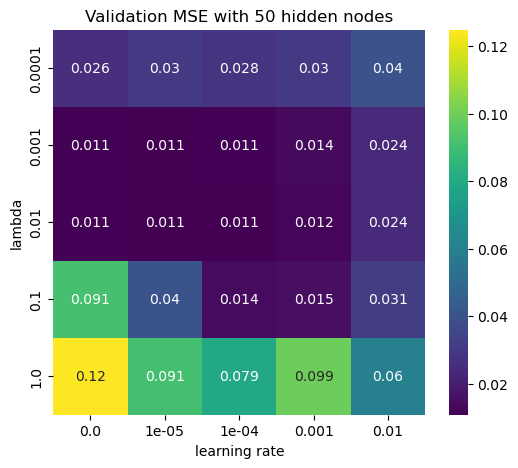

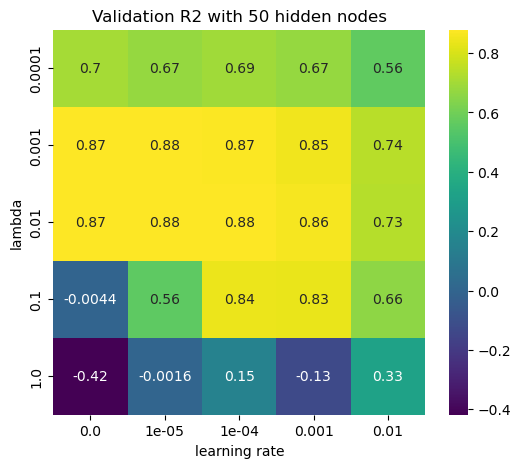

In [78]:
n_hidden_layers = 2
n_hidden_nodes_list = [50]
n_outputs = 1
n_features = X_train.shape[1]

activation_hidden = "ReLU"

learning_rates = np.logspace(-4, 0, 5)
lmbd_vals = np.logspace(-5, -2, 4)
lmbd_vals = jnp.insert(lmbd_vals, 0, 0.0)

mse = np.zeros((len(n_hidden_nodes_list), len(learning_rates), len(lmbd_vals)))
r2 = np.zeros((len(n_hidden_nodes_list), len(learning_rates), len(lmbd_vals)))

kfold = KFold(n_splits=4, shuffle=True)


for k, n_hidden_nodes in enumerate(n_hidden_nodes_list):

    for i, lr in tqdm(enumerate(learning_rates)):

        for j, lmbd in enumerate(lmbd_vals):

            mse_crossval = []
            r2_crossval = []

            for train_index, val_index in kfold.split(X_train):

                X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
                target_train_cv, target_val_cv = target_train[train_index], target_train[val_index]

                grad_cost_function = grad_mse(target_train_cv)

                ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                      cost_function=grad_cost_function,
                                      learning_rate=lr, 
                                      lmbd=lmbd, 
                                      activation_function_hidden=activation_hidden,
                                      activation_function_output='Linear',
                                      optimizer=None,
                                      classification_problem=False)

                ffnn.train(X_train_cv, num_iter=100)
                pred_val = ffnn.predict(X_val_cv)

                mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
                r2_crossval.append(r2_score(target_val_cv, pred_val))


            mse[k][i][j] = np.mean(mse_crossval)
            r2[k][i][j] = np.mean(r2_crossval)


    plot_heatmap(mse[k, :, :], x_ticks=lmbd_vals, y_ticks=learning_rates, x_label="lambda", 
                 y_label="learning rate", title=f"Validation MSE with {n_hidden_nodes} hidden nodes")

    plot_heatmap(r2[k, :, :], x_ticks=lmbd_vals, y_ticks=learning_rates, x_label="lambda", 
                 y_label="learning rate", title=f"Validation R2 with {n_hidden_nodes} hidden nodes")

